In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import math

import time
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, zero_one_loss, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import callbacks
from keras import losses


In [2]:
def reduce_memory_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

In [3]:
# 1. Carica il test set
test_set = pd.read_csv('../archive/test_set3_processed.csv')
test_set = reduce_memory_usage(test_set)

train_b=pd.read_csv('../archive/train_b.csv')
train_b = reduce_memory_usage(train_b)
print(f"Dimensione training set: {len(train_b)}")
print(f"Dimensione Test Set: {len(test_set)}")


Dimensione training set: 8444945
Dimensione Test Set: 2402405


In [4]:
autoencoder=models.load_model('../archive/model3')
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 5)                 1145      
                                                                 
 decoder (Sequential)        (None, 43)                1183      
                                                                 
Total params: 2,328
Trainable params: 2,328
Non-trainable params: 0
_________________________________________________________________


## Calcolo la soglia 99° percentile

In [5]:
X_train_predicted = autoencoder.predict(x=train_b)

train_events_mse = losses.mean_squared_error(train_b, X_train_predicted)
cut_off = np.percentile(train_events_mse, 99)
print('Threshold (99 pctile): ',cut_off)

263905/263905 [==============================] - 613s 2ms/step
Threshold (99 pctile):  0.010797960832714944


## Calcolo la soglia 95° percentile

In [7]:
cut_off_95 = np.percentile(train_events_mse, 95)
print('Threshold (95 pctile): ',cut_off_95)

Threshold (95 pctile):  0.0015756306005641808


In [8]:
print(train_events_mse.shape,'\n')

(8444945,) 



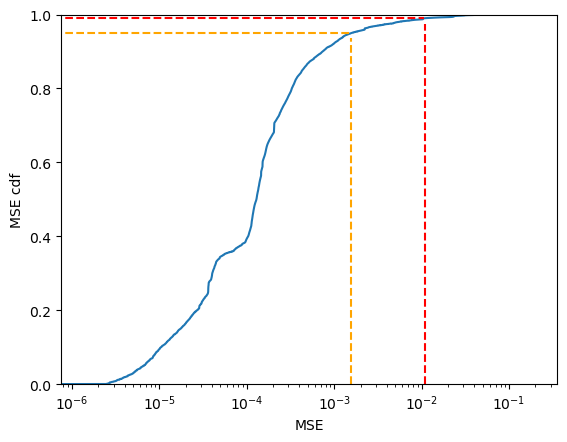

In [8]:
ax=sns.ecdfplot(data=train_events_mse)
ax.set(xscale="log")
ax.set_xlabel('MSE')
ax.set_ylabel('MSE cdf')

n_points=40
line_h1 = Line2D(xdata=np.arange(0, cut_off,cut_off/n_points),ydata=np.full(n_points, 0.99),color='red',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_h1)
line_v1 = Line2D(xdata=np.full(n_points,cut_off),ydata=np.arange(0, 0.99, 1/n_points),color='red',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_v1)

line_h2 = Line2D(xdata=np.arange(0, cut_off_95,cut_off_95/n_points),ydata=np.full(n_points, 0.95),color='orange',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_h2)
line_v2 = Line2D(xdata=np.full(n_points,cut_off_95),ydata=np.arange(0, 0.95, 0.96/n_points),color='orange',linewidth=1.5,linestyle='dashed')
ax.add_artist(line_v2)

In [6]:

X_test_b=test_set[test_set['target']==0]
y_true_b=X_test_b['target']
X_test_b=X_test_b.drop(columns=['target'])


X_test_a=test_set[test_set['target']==1]
y_true_a=X_test_a['target']
X_test_a=X_test_a.drop(columns=['target'])


y_true= pd.concat([y_true_b, y_true_a], ignore_index=True)

(100, 43)
4/4 [==============================] - 0s 8ms/step
(100, 43)
4/4 [==============================] - 0s 5ms/step


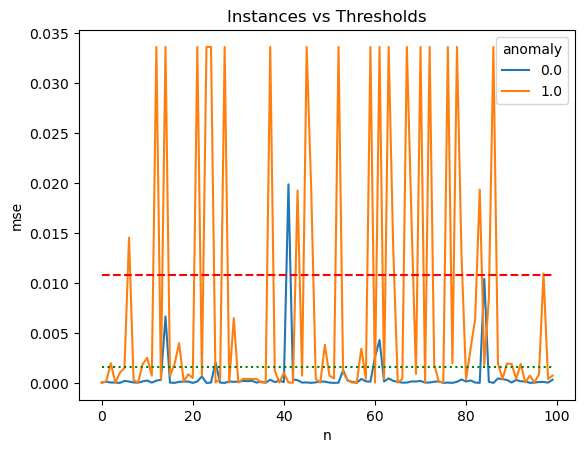

In [12]:
plot_samples = 100
n_features = train_b.shape[1]
# normal event
real_x = X_test_b[:plot_samples].to_numpy().reshape(plot_samples, n_features)
print(real_x.shape)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({'mse': normal_events_mse, 'n': np.arange(0, plot_samples), 'anomaly': np.zeros(plot_samples)})

# abnormal event
abnormal_x = X_test_a[:plot_samples].to_numpy().reshape(plot_samples, n_features)
print(abnormal_x.shape)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = losses.mean_squared_error(abnormal_x, predicted_x)

abnormal_events_df = pd.DataFrame({'mse': abnormal_events_mse, 'n': np.arange(0, plot_samples), 'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
mse_df = mse_df.reset_index()
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = Line2D(xdata=np.arange(0, plot_samples),ydata=np.full(plot_samples, cut_off),color='red',linewidth=1.5,linestyle='dashed')
line2 = Line2D(xdata=np.arange(0, plot_samples),ydata=np.full(plot_samples, cut_off_95),color='green',linewidth=1.5,linestyle='dotted')

plot.add_artist(line)
plot.add_artist(line2)
plt.title('Instances vs Thresholds')
plt.show()

In [13]:
X_test_b.shape

(2111401, 43)

In [14]:
X_test_a.shape

(291004, 43)

# Build the Confusion Matrix

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
samples_b = X_test_b.shape[0]
n_features = train_b.shape[1]
# normal event

#real_x_b trasforma il dataframe pandas in un array numpy 
real_x_b = X_test_b.to_numpy().reshape(samples_b, n_features)
t_0=time.monotonic()
#predicted_x_b contiene la ricostruzione di X_test_b fatta dall'autoencoder
predicted_x_b = autoencoder.predict(x=real_x_b)
#normal_events_mse_ext misura il mse tra la previsione e l'originale dei soli campioni benigni
normal_events_mse_ext = losses.mean_squared_error(real_x_b, predicted_x_b)
t_1=time.monotonic()
#normal_events_mse_ext viene organizzato in un dataframe pandas con la colonna chiamata 'mse'
normal_events_df_ext = pd.DataFrame({'mse': normal_events_mse_ext})

# abnormal event
samples_a = X_test_a.shape[0]
t_2=time.monotonic()
abnormal_x_a = X_test_a.to_numpy().reshape(samples_a, n_features)
predicted_x_a = autoencoder.predict(x=abnormal_x_a)
abnormal_events_mse_ext = losses.mean_squared_error(abnormal_x_a, predicted_x_a)
t_3=time.monotonic()
abnormal_events_df_ext = pd.DataFrame({'mse': abnormal_events_mse_ext})

print('Normal instance: ',(t_1-t_0)/samples_b*1e6,' us per sample\n')
print('Anomaly instance: ',(t_3-t_2)/samples_a*1e6,' us per sample\n')
mse_tot = pd.concat([abnormal_events_df_ext, normal_events_df_ext], ignore_index=True)

# threshold = 0.010797960832714944

# y_pred = (mse_tot > threshold).astype(int)  # 1 per anomalia, 0 per normale

# # 7. Calcola le metriche di performance
# accuracy = accuracy_score(y_true, y_pred)

# # Precision e Recall separati per ciascuna classe (0=benigno, 1=maligno)
# precision = precision_score(y_true, y_pred, average=None)
# recall = recall_score(y_true, y_pred, average=None)

# # 8. Matrice di confusione
# conf_matrix = confusion_matrix(y_true, y_pred)

# # 9. Stampa i risultati
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision Benigni (0): {precision[0]:.4f}")
# print(f"Precision Maligni (1): {precision[1]:.4f}")
# print(f"Recall Benigni (0): {recall[0]:.4f}")
# print(f"Recall Maligni (1): {recall[1]:.4f}")
# print("Matrice di Confusione:")
# print(conf_matrix)

9094/9094 [==============================] - 22s 2ms/step
Normal instance:  87.58260510438612  us per sample

Anomaly instance:  89.56234278564777  us per sample

Accuracy: 0.8505
Precision Benigni (0): 0.8763
Precision Maligni (1): 0.0395
Recall Benigni (0): 0.9663
Recall Maligni (1): 0.0101
Matrice di Confusione:
[[2040276   71125]
 [ 288079    2925]]


In [16]:
#calcolo dei falsi negativi: abnormal_events_df_ext contiene i valori di mse calcolati SOLO sui campioni anomali, 
#perciò il numero di valori di mse che è inferiore a cut_off sarebbe classificato dal modello come benigno erroneamente. 
#Sono i falsi benigni 
count_fn = len(abnormal_events_df_ext[abnormal_events_df_ext.mse <= cut_off].value_counts())

In [17]:
#l'insieme dei falsi maligni, quindi tutti i campioni > cut_off che dal classificatore sarebbero classificati come anomali 
#appunto perché > cut_off ma in realta sono benigni
count_fp = len(normal_events_df_ext[normal_events_df_ext.mse > cut_off].value_counts())

In [18]:
#veri maligni : totale campioni maligni - quelli classificati come benigni ma erano maligni (quindi i maligni mancati) 
tp = samples_a - count_fn

In [19]:
#veri benigni: tatale campioni benigni - benigni mancati 
tn = samples_b - count_fp

In [20]:
conf_mat = [[tp, count_fn],[count_fp, tn]]

In [21]:
conf_mat = np.array(conf_mat)

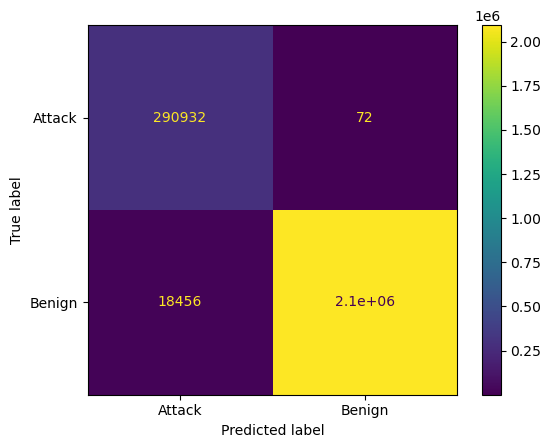

In [22]:
labels_cm = ['Attack' , 'Benign']
disp_cm = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels_cm)
disp_cm.plot()
plt.show()

In [23]:
precision_attack=(tp)/(tp+count_fp)
print('Precision (attack): ',precision_attack)

precision_benign=(tn)/(tn+count_fn)
print('Precision (benign): ',precision_benign)

Precision (attack):  0.9403467490658979
Precision (benign):  0.9999655998971819


In [24]:
recall_attack=(tp)/(tp+count_fn)
print('Recall (attack): ',recall_attack)
recall_benign=(tn)/(tn+count_fp)
print('Recall (benign): ',recall_benign)

Recall (attack):  0.99975258072054
Recall (benign):  0.9912588845037016


In [25]:
accuracy=(tp+tn)/(tp+tn+count_fn+count_fp)
print('Accuracy: ',accuracy)

Accuracy:  0.9922877283388938
